# Sample notebook for rotating and scaling an individual eddy

Example using intake catalogs, opening a large model dataset and picking out one eddy from the fields based on provided coordinates.

## Method:

  1. Select region within $\pm$ N degrees latitude/longitude of eddy centre. This region should be large enough to include the requested locations in the transformed composite coordinates.
  3. Transform from latitude/longitude coordinates to local cartesian coordinates with unit vectors $\mathbf{e}_i$.
  4. Apply a scaling/rotation coordinate transform such that $\mathbf{e'}_1$ is in the direction of large-scale wind and $|\mathbf{e'}_i|=R_{eddy}$.
  5. Resample data in the transformed composite coordinate system.

## Transformation of basis vectors
The basis vectors in the new coordinate system ($\mathbf{e'_i}$) are derived from the original component vectors as follows:

$\mathbf{e}_i = \frac{1}{R_{eddy}}\mathbf{T}\mathbf{e}_i$,

where $R_{eddy}$ is the radius of the specified eddy, $\theta$ is the required anti-clockwise rotation, and $\mathbf{T}$ is a 2D rotation transformation matrix given by

$\mathbf{T} = \begin{pmatrix} cos\theta & -sin\theta \\ sin\theta & cos\theta \end{pmatrix}$.


## Transforming vector components in new basis back to the original basis.
The linear transformation of vector components is the inverse of the matrix that transforms the basis vectors. Pure rotational transforms are orthogonal and thus $\mathbf{T^T}\equiv\mathbf{T^{-1}}$. The components of a vector in the original basis ($x_i$) can thus be derived from components in the new basis ($x'_i$) using the the following transformation: 

$\begin{pmatrix} x_1 \\ x_2 \end{pmatrix} = R_{eddy}\mathbf{T^T}\begin{pmatrix} x'_1 \\ x'_2 \end{pmatrix},$

where 

$\mathbf{x} = x_1 \mathbf{e}_1 + x_2 \mathbf{e}_2 = x'_1 \mathbf{e}'_1 + x'_2 \mathbf{e}'_2$.

## Imports

In [2]:
import intake

import xarray as xr
xr.set_options(keep_attrs=True)

import eddytransform as et
import os

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs

/home/users/aengenh/.conda/envs/science312/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


## Parameter settings

In [30]:
# Specify EERIE data
# CATALOG = "/home/neam/code/intake_atos/eerie.yaml"
MODEL='HadGEM3-GC5-EERIE-N640'
EXP='highresSST-present'
DATASET='Aday'
gridtype = 'regular' # irregular # is the data on a 'regular' lat on grid or other?
realization = 1

# time/lon/lat coordinates of imagined eddy
# TIME = '2021-01-11 12:00:00'
TIME = '2008-01-11 12:00:00'
EDDY_LON = 289
EDDY_LAT = 39.5

# varname = 'avg_sst'
varname = 'ts'

In [5]:
# Settings for eddy transformation - decent default values
DOMAIN_HALF_WIDTH_IN_DEGREES = 20 # domain half width
AVG_WIND_EDDY_RADIUSES = 3 # Number of eddy radiuses used for calculating direction of large-scale winds. 
RESAMPLE_EDDY_RADIUSES = 3 # Number of eddy radiuses to sample in transformed composite coordinates.
RESAMPLE_DENSITY = 30 # Number of data points per eddy radius in transformed composite coordinates.
UPARAM = "uas" # zonal surface wind velocity, for eddy rotation
VPARAM = "vas" # meridional surface wind velocity, for eddy rotation

## Read & process data 

In [28]:
print('Open datasets')
ds = et.open_mohc_jasmin(
    MODEL,
    EXP,
    DATASET,
    [varname,UPARAM,VPARAM],
    sel=dict(time=slice('2000','2009'))
)


# if gridtype == 'regular':
#     print('Reshape regular catalog to 2D coordinates')
#     ds = et.reshape_latlon_1d_to_latlon_2d(ds)
#     sort = True
# else:
#     sort = False

# if 'realization' in ds.dims:
#     ds = ds.sel(realization=realization)

# lontype = et.identify_lontype(ds=ds)
# if lontype == '180':
#     print('Change longitude to 0-360 to align with eddy tracks')
#     ds = et.lon_180_to_360(ds,sort=sort)


Open datasets
Get variables: ['ts', 'uas', 'vas']
ts
Get 137 files
uas
Get 120 files
vas
Get 120 files
Merging variables


lontype identified as 360
assume regular grid
lontype identified as 360
assume regular grid


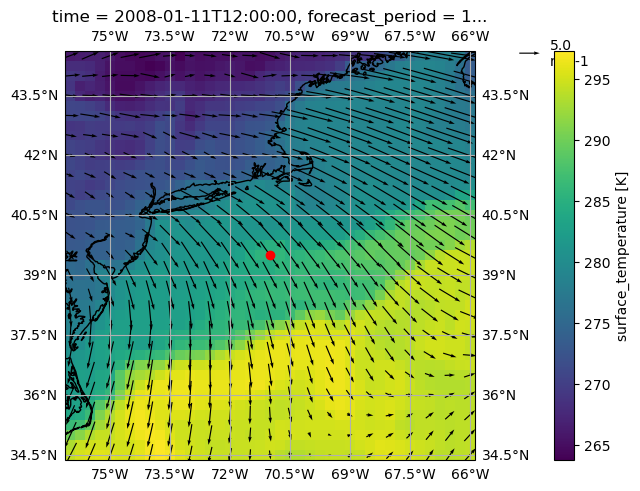

In [31]:
fig, ax = plt.subplots(constrained_layout=True,subplot_kw=dict(projection=ccrs.PlateCarree()))
cf = et.sel_region(
    ds[varname].sel(
        time=TIME
    ),
    # 360+EDDY_LON,EDDY_LAT,5
    EDDY_LON,EDDY_LAT,5
).plot(transform=ccrs.PlateCarree())

quiver = et.sel_region(
    ds[[UPARAM,VPARAM]].sel(
        time=TIME
    ),
    # 360+EDDY_LON,EDDY_LAT,5
    EDDY_LON,EDDY_LAT,5
).isel(lon=slice(None,None, 2),lat=slice(None,None, 2)).plot.quiver(
    x='lon', y='lat', u=UPARAM, v=VPARAM, scale=100
)

ax.set_facecolor('grey')
ax.gridlines(draw_labels=True)
ax.coastlines(lw=1)

ax.plot(EDDY_LON,EDDY_LAT,'ro',transform=ccrs.PlateCarree())

## Transform eddy

In [32]:
eddy_centered = et.transform_eddy(
    ds,
    COMPOSITE_PARAM = varname,
    TIME_DX = TIME,
    EDDY_LON = EDDY_LON,
    EDDY_LAT = EDDY_LAT,
    DOMAIN_HALF_WIDTH_IN_DEGREES = DOMAIN_HALF_WIDTH_IN_DEGREES,
    EDDY_RADIUS = 100,
    AVG_WIND_EDDY_RADIUSES = AVG_WIND_EDDY_RADIUSES,
    RESAMPLE_EDDY_RADIUSES = RESAMPLE_EDDY_RADIUSES,
    RESAMPLE_DENSITY = RESAMPLE_DENSITY,
    UPARAM = UPARAM,
    VPARAM = VPARAM,
)

['ts', '2008-01-11 12:00:00', 289, 39.5, 20, 100, 3, 3, 30, 'uas', 'vas']
lontype identified as 360
lontype identified as 360
assume regular grid
Assume regular grid
wind direction, assuming regular grid


## Rotate near-surface winds

In [33]:
eddy_centered_winds = et.transform_winds(
    ds[[UPARAM,VPARAM]],
    TIME_DX = TIME,
    EDDY_LON = EDDY_LON,
    EDDY_LAT = EDDY_LAT,
    DOMAIN_HALF_WIDTH_IN_DEGREES = DOMAIN_HALF_WIDTH_IN_DEGREES,
    EDDY_RADIUS = 100,
    AVG_WIND_EDDY_RADIUSES = AVG_WIND_EDDY_RADIUSES,
    RESAMPLE_EDDY_RADIUSES = RESAMPLE_EDDY_RADIUSES,
    RESAMPLE_DENSITY = RESAMPLE_DENSITY,
    UPARAM = UPARAM,
    VPARAM = VPARAM
)

['rotate u/v', '2008-01-11 12:00:00', 289, 39.5, 20, 100, 3, 3, 30, 'uas', 'vas']
lontype identified as 360
lontype identified as 360
assume regular grid
Assume regular grid
wind direction, assuming regular grid
Wind angle: -0.91 rad, -52.22 deg


In [34]:
eddy_centered = xr.merge(
    [
        eddy_centered,
        eddy_centered_winds
    ]
)

Text(1.0, 1.0, '2008-01-11 12:00:00')

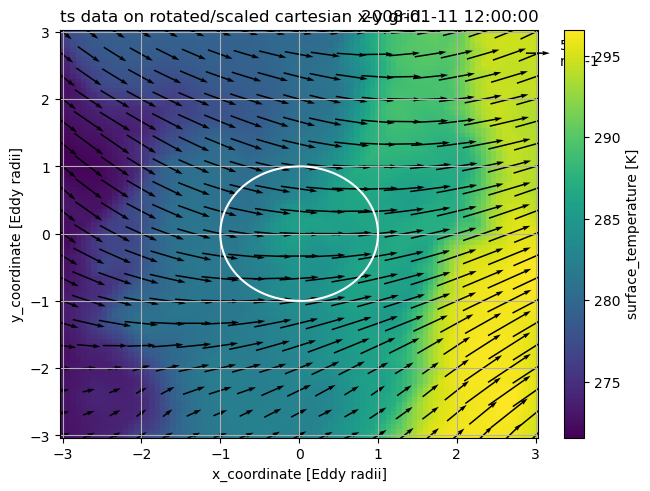

In [35]:
fig, ax = plt.subplots(constrained_layout=True)#,subplot_kw=dict(projection=ccrs.PlateCarree()))
eddy_centered[varname].plot(ax=ax)#cmap=cmo.thermal)

theta = np.linspace(0,2*np.pi,100)

plt.plot(
    np.cos(theta),
    np.sin(theta),
    'w'
)

eddy_centered.isel(
    x=slice(None,None, 5),y=slice(None,None, 5)
).plot.quiver(
    x='x',y='y',u=UPARAM,v=VPARAM,scale=100,
    ax=ax
)

ax.set_facecolor('grey')
ax.grid(True)

ax.set_title(f"{varname} data on rotated/scaled cartesian x-y grid.",loc='left')
ax.set_title(TIME,loc='right')


In [36]:
print('DONE')

DONE
